In [1]:
import argparse
from collections import defaultdict
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import scanpy as sp
from scipy.stats import spearmanr
from sklearn.cluster import KMeans
import seaborn as sns
from tqdm import tqdm

In [2]:
def add_quant_col(gene_df,col):
    gene_df[col + "_quant"] =  np.nan
    gene_df.loc[~gene_df[col].isna(),col + "_quant"] = 1

    gene_df.loc[gene_df[col] > gene_df[col].quantile(.25),col + "_quant"] = 2
    gene_df.loc[gene_df[col] > gene_df[col].quantile(.5),col + "_quant"] = 3
    gene_df.loc[gene_df[col] > gene_df[col].quantile(.75),col + "_quant"] = 4
    return gene_df

In [3]:
def load_gtf(gtf_file,filt_chr):
  gtf = pd.read_csv(gtf_file, names = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"], skiprows=7,sep="\t")
  if 'NC_000023.11' in gtf["seqname"].unique():
    can_chrom = [x for x in gtf["seqname"].unique() if x.startswith("NC_")]
    name_dict = {x : "chr" + str(int(x.split("_")[1].split(".")[0])) for x in can_chrom}
    name_dict['NC_000023.11'] = "chrX"
    name_dict['NC_000024.10'] = "chrY"
    name_dict['NC_012920.1'] = "chrM"
    gtf["seqname"] = gtf["seqname"].map(name_dict)
    gtf = gtf[~gtf["seqname"].isna()]
    filt_chr = False
  #   gtf = gtf[gtf["feature"] == "exon"]
#   try:
  gtf["gene_name"] = gtf["attribute"].str.split("gene_name=").str[1].str.split(";").str[0]
  gtf["gene_id"] = gtf["attribute"].str.split("gene_id=").str[1].str.split(";").str[0].str.split(".").str[0]
#   gtf["gene_name"] = gtf["attribute"].str.split("gene_name").str[1].str.split(";").str[0].str.split('"').str[1]
#   gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]

  #   except:
#     gtf["gene_id"] = gtf["attribute"].str.split("gene_id").str[1].str.split(";").str[0].str.split('"').str[1]
#   gtf["transcript_id"] = gtf["attribute"].str.split("transcript_id").str[1].str.split(";").str[0].str.split('"').str[1]
#  filt_chr = True
  if filt_chr:
    # don't include immature scaffolds
    chromosomes = gtf["seqname"].unique()
    chromosomes = [x for x in chromosomes if "_" not in x and not x.startswith("KN")]
#    print("chromosomes",chromosomes)
    gtf = gtf[gtf["seqname"].isin(chromosomes)]
  gtf["chr_gene"] = gtf["seqname"] + gtf["gene_id"]
  return gtf

In [4]:
{ }

In [14]:
{v for v in name_dict.keys() if "Rps24" in name_dict[v]}

{'chr10_25699_minus', 'chr10_25700_minus'}

In [15]:
name_dict["chr10_25699_minus"]

'Myl6,Myl6b'

In [16]:
name_dict["chr10_25700_minus"]

'Myl6b'

In [25]:
name_dict = defaultdict(lambda x : x)
for win, windf in tqdm(ens.dropna().drop_duplicates(["full_window","gene_name"]).groupby("full_window")):
  name_dict[win] = ",".join(list(windf["gene_name"]))


100%|██████████| 279468/279468 [00:23<00:00, 12124.53it/s]


In [19]:
dataname = "V1_Mouse_Kidney"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior"
# dataname = "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior"
# dataname = "V1_Mouse_Brain_Sagittal_Posterior_Section_2"
# dataname = "cta_ucsf-1-5_liver"

samples = pd.read_csv("output/make_samplesheet/spatial.csv",index_col = 0)
# samples
row = samples.loc[dataname]

# dataname="chr1_sample"

# method = "ReadZS"
# method = "ge"
method = "ReadZS"

# supdir = "/oak/stanford/groups/horence/JuliaO/nf-spliz-output/run_dir/visium/"
# supdir = "/oak/stanford/groups/horence/JuliaO/nf-spliz-output/intron_retention/"
if method == "ge":
  col = "frac_count"
#   method = "ge"
  genecol = "gene"
  # spliz_path = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/scripts/output/parse_gene_expression/{}_sub_1000.tsv".format(dataname)
#   spliz_path = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/scripts/output/parse_gene_expression/{}.pq".format(dataname)
  cellid = "cell_id"
  # spliz_path = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/scripts/output/parse_gene_expression/V1_Mouse_Kidney_count_Usp9y_Kdm5d.pq"
  valpath = "ge_vals"
elif method == "ReadZS":
  col = "z_scaled"
#   method = "ReadZS"
  genecol = "window"
#   spliz_path = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/{}_all_5000.zscore".format(dataname,dataname)
  cellid = "cell_id"
  valpath = "readzs_vals"
elif method == "SpliZ":
  col = "scZ"
#   method = "SpliZ"
  genecol = "gene"
#   spliz_path = "{}{}/SpliZ_values/{}_sym_SVD_normdonor_S_0.1_z_0.0_b_5_r_0.01_subcol.tsv".format(supdir,dataname,dataname)
  cellid = "cell"
  valpath = "spliz_vals"
  


In [10]:

# if spliz_path.endswith(".pq"):
#   spliz_df = pd.read_parquet(spliz_path)
# else:
spliz_df = pd.read_csv(row[valpath],sep="\t")
  
if dataname == "cta_ucsf-1-5_liver":
  filt_bc_name = "/oak/stanford/groups/horence/JuliaO/data/visium/Biohub_covid_liver/cta_ucsf-1-5_liver/outs/filtered_feature_bc_matrix/barcodes.tsv.gz"
  filt_bc = pd.read_csv(filt_bc_name,names=["barcode"])
  
  spliz_df = spliz_df[spliz_df["barcode"].isin(set(filt_bc["barcode"]))]
# meta_path = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/notebooks/visium_meta/meta_{}.tsv".format(dataname)
# meta = pd.read_csv(meta_path,sep="\t")
# spliz_df = spliz_df[[x for x in spliz_df.columns if ((x not in meta.columns) | (x == "cell_id"))]].merge(meta,on="cell_id")
# spliz_df = spliz_df[~(spliz_df["xcoord"].isna())]
# spliz_df.to_csv(spliz_path,sep="\t",index=False)

In [11]:
spliz_df

,cell_id,chrom,read_strand,window,channel,z_scaled,count,clust_3,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant
0,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_881_minus,V1_Mouse_Kidney,-0.351217,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
1,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_1745_minus,V1_Mouse_Kidney,0.356927,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
2,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_2705_minus,V1_Mouse_Kidney,-0.282633,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
3,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_7991_minus,V1_Mouse_Kidney,-1.491564,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
4,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_7994_minus,V1_Mouse_Kidney,-0.755092,2,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884115,V1_Mouse_Kidney_GTGATTCGCCGCTCAA,chr7,-,chr7_9092_minus,V1_Mouse_Kidney,-1.266199,1,2.0,GTGATTCGCCGCTCAA-1,1,48,40,6828,3980,3980,-6828,84,1
6884116,V1_Mouse_Kidney_GTGATTCGCCGCTCAA,chr7,-,chr7_20766_minus,V1_Mouse_Kidney,1.269068,1,2.0,GTGATTCGCCGCTCAA-1,1,48,40,6828,3980,3980,-6828,84,1
6884117,V1_Mouse_Kidney_GTGATTCGCCGCTCAA,chr7,-,chr7_21112_minus,V1_Mouse_Kidney,1.905114,1,2.0,GTGATTCGCCGCTCAA-1,1,48,40,6828,3980,3980,-6828,84,1
6884118,V1_Mouse_Kidney_GTGATTCGCCGCTCAA,chr9,-,chr9_4426_minus,V1_Mouse_Kidney,-0.346860,1,2.0,GTGATTCGCCGCTCAA-1,1,48,40,6828,3980,3980,-6828,84,1


In [62]:
spliz_df[spliz_df[genecol].str.startswith("chr10_25699")]

,cell_id,chrom,read_strand,window,channel,z_scaled,count,clust_3,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant


In [64]:
spliz_df[spliz_df[genecol].str.startswith("chr10")]

,cell_id,chrom,read_strand,window,channel,z_scaled,count,clust_3,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant
0,V1_Mouse_Brain_Sagittal_Posterior_Section_2_AA...,chr10,-,chr10_252_minus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,-0.987956,1,1.0,AAACAAGTATCTCCCA-1,1,50,102,7543,8555,8555,-7543,137,4
1,V1_Mouse_Brain_Sagittal_Posterior_Section_2_AA...,chr10,-,chr10_258_minus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,-1.027105,1,1.0,AAACAAGTATCTCCCA-1,1,50,102,7543,8555,8555,-7543,137,4
2,V1_Mouse_Brain_Sagittal_Posterior_Section_2_AA...,chr10,-,chr10_292_minus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,0.351327,1,1.0,AAACAAGTATCTCCCA-1,1,50,102,7543,8555,8555,-7543,137,4
3,V1_Mouse_Brain_Sagittal_Posterior_Section_2_AA...,chr10,-,chr10_345_minus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,1.452640,1,1.0,AAACAAGTATCTCCCA-1,1,50,102,7543,8555,8555,-7543,137,4
4,V1_Mouse_Brain_Sagittal_Posterior_Section_2_AA...,chr10,-,chr10_356_minus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,0.502577,1,1.0,AAACAAGTATCTCCCA-1,1,50,102,7543,8555,8555,-7543,137,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13763725,V1_Mouse_Brain_Sagittal_Posterior_Section_2_TT...,chr10,+,chr10_6422_plus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,-1.858796,1,2.0,TTGTTTGTATTACACG-1,1,73,41,10298,4355,4355,-10298,139,5
13763726,V1_Mouse_Brain_Sagittal_Posterior_Section_2_TT...,chr10,+,chr10_6425_plus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,0.211374,4,2.0,TTGTTTGTATTACACG-1,1,73,41,10298,4355,4355,-10298,139,5
13763727,V1_Mouse_Brain_Sagittal_Posterior_Section_2_TT...,chr10,+,chr10_6439_plus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,-0.897516,2,2.0,TTGTTTGTATTACACG-1,1,73,41,10298,4355,4355,-10298,139,5
13763728,V1_Mouse_Brain_Sagittal_Posterior_Section_2_TT...,chr10,+,chr10_6441_plus,V1_Mouse_Brain_Sagittal_Posterior_Section_2,-0.279314,1,2.0,TTGTTTGTATTACACG-1,1,73,41,10298,4355,4355,-10298,139,5


In [66]:
spliz_df["win"] = spliz_df["window"].str.split("_").str[1]

In [67]:
spliz_df["win"] = spliz_df["win"].astype(int)

In [68]:
spliz_df["win"].sort_values().unique()

array([  43,   45,   46, ..., 9758, 9759, 9761])

In [10]:
# spliz_df["win"] = spliz_df["window"].str.split("_").str[1].astype(int)
# spliz_df["gene_name"] = spliz_df["win"].map({k : v for k, v in zip(ens["window"],ens["gene_name"])})

In [11]:
# # outpath = "/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/notebooks/output/plot_gene/"

# outfile = "{}ensembl.txt".format(outpath)
# f = open(outfile,"w")
# for ind, row in ens.drop_duplicates("gene_id").iterrows():

#   f.write(row["gene_id"] + "\n")
# f.close()
# print(outfile)
# spliz_df["ensembl"] = spliz_df["win"].map(window_dict)

In [20]:

outpath = "output/plot_gene/"

# im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/{}/{}_image.tif".format(dataname,dataname)
# if dataname == "cta_ucsf-1-5_liver":
#   im_path = "/oak/stanford/groups/horence/JuliaO/data/visium/Biohub_covid_liver/cta_ucsf-1-5_liver_HE_4x_001.tif"
thresh = 5
xcol = "plot_xcoord"
ycol = "plot_ycoord"
alpha = 0.2



Image.MAX_IMAGE_PIXELS = 178956970
im = Image.open(row["image"])
graydf = spliz_df.drop_duplicates(cellid)

In [13]:
corrdf = pd.read_csv("/scratch/groups/horence/JuliaO/single_cell/spatial_kmers/scripts/output/pixel_correlation/{}_{}_100.tsv".format(dataname,col),sep="\t")
corrdf.head(20)

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj
0,chr11_2746_plus,1435,-0.250160,6.484823e-22,-0.250223,6.330396e-22,7.706564e-18,7.523043e-18
1,chr4_5858_minus,1423,0.225131,8.279363e-18,0.218323,8.140935e-17,4.919598e-14,4.837343e-13
2,chr4_5964_minus,1316,0.209451,1.638070e-14,0.206987,3.351956e-14,6.488942e-11,1.327821e-10
3,chr11_291_minus,1334,0.196069,5.020451e-13,0.194030,8.796843e-13,1.193261e-09,2.090834e-09
4,chr7_2230_plus,1433,-0.189986,4.113222e-13,-0.190928,3.135770e-13,1.193261e-09,9.316372e-10
5,chr6_6693_minus,1434,0.184669,1.819063e-12,0.185086,1.619156e-12,3.602957e-09,3.207009e-09
6,chr1_4327_plus,1365,-0.185507,4.932742e-12,-0.183293,8.877597e-12,8.374387e-09,1.507162e-08
7,chr4_6481_plus,1123,-0.179874,1.273737e-09,-0.175657,3.103277e-09,1.892137e-06,3.687934e-06
8,chr11_6029_minus,1403,-0.159485,1.890623e-09,-0.158679,2.284355e-09,2.496463e-06,3.393409e-06
9,chr17_1993_plus,1433,-0.155217,3.495443e-09,-0.156011,2.902418e-09,4.153985e-06,3.687934e-06


In [42]:
corrdf[corrdf["window"] == "chr8_183_plus"]

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj,gene,num_genes
58,chr8_183_plus,792,0.141119,0.000067,0.139175,0.000085,0.013585,0.015793,NaN,NaN


In [27]:
spliz_df[spliz_df["window"] == "chr10_25699_minus"]

,cell_id,chrom,read_strand,window,channel,z_scaled,count,clust_3,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant


In [29]:
spliz_df[spliz_df["chrom"] == "chr10"]

,cell_id,chrom,read_strand,window,channel,z_scaled,count,clust_3,barcode,in_tissue,array_row,array_col,xcoord,ycoord,plot_xcoord,plot_ycoord,pixval,pixquant
0,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_221_minus,V1_Mouse_Kidney,-0.368317,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
1,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_437_minus,V1_Mouse_Kidney,0.335104,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
2,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_677_minus,V1_Mouse_Kidney,-0.298140,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
3,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_1998_minus,V1_Mouse_Kidney,-0.886713,1,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
4,V1_Mouse_Kidney_AAACCGTTCGTCCAGG,chr10,-,chr10_1999_minus,V1_Mouse_Kidney,-0.760593,2,2.0,AAACCGTTCGTCCAGG-1,1,52,42,7307,4116,4116,-7307,81,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6496716,V1_Mouse_Kidney_TTGTTTCACATCCAGG,chr10,+,chr10_6426_plus,V1_Mouse_Kidney,-1.519100,1,2.0,TTGTTTCACATCCAGG-1,1,58,42,8025,4113,4113,-8025,86,2
6496717,V1_Mouse_Kidney_TTGTTTCACATCCAGG,chr10,+,chr10_6428_plus,V1_Mouse_Kidney,-0.403852,1,2.0,TTGTTTCACATCCAGG-1,1,58,42,8025,4113,4113,-8025,86,2
6496718,V1_Mouse_Kidney_TTGTTTCACATCCAGG,chr10,+,chr10_6441_plus,V1_Mouse_Kidney,-0.526031,1,2.0,TTGTTTCACATCCAGG-1,1,58,42,8025,4113,4113,-8025,86,2
6496719,V1_Mouse_Kidney_TTGTTTCACATCCAGG,chr10,+,chr10_6444_plus,V1_Mouse_Kidney,0.315364,3,2.0,TTGTTTCACATCCAGG-1,1,58,42,8025,4113,4113,-8025,86,2


In [14]:
# corrdf["win"] = corrdf["window"].str.split("_").str[1].astype(int)
# corrdf["ensembl"] = corrdf["win"].map(window_dict)
corrdf["gene"] = corrdf["window"].map(name_dict)
corrdf["num_genes"] = corrdf["gene"].str.count(",") + 1
corrdf.head(20)

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj,gene,num_genes
0,chr11_2746_plus,1435,-0.250160,6.484823e-22,-0.250223,6.330396e-22,7.706564e-18,7.523043e-18,NaN,NaN
1,chr4_5858_minus,1423,0.225131,8.279363e-18,0.218323,8.140935e-17,4.919598e-14,4.837343e-13,NaN,NaN
2,chr4_5964_minus,1316,0.209451,1.638070e-14,0.206987,3.351956e-14,6.488942e-11,1.327821e-10,NaN,NaN
3,chr11_291_minus,1334,0.196069,5.020451e-13,0.194030,8.796843e-13,1.193261e-09,2.090834e-09,NaN,NaN
4,chr7_2230_plus,1433,-0.189986,4.113222e-13,-0.190928,3.135770e-13,1.193261e-09,9.316372e-10,NaN,NaN
5,chr6_6693_minus,1434,0.184669,1.819063e-12,0.185086,1.619156e-12,3.602957e-09,3.207009e-09,NaN,NaN
6,chr1_4327_plus,1365,-0.185507,4.932742e-12,-0.183293,8.877597e-12,8.374387e-09,1.507162e-08,NaN,NaN
7,chr4_6481_plus,1123,-0.179874,1.273737e-09,-0.175657,3.103277e-09,1.892137e-06,3.687934e-06,Bach2,1.0
8,chr11_6029_minus,1403,-0.159485,1.890623e-09,-0.158679,2.284355e-09,2.496463e-06,3.393409e-06,Sptbn1,1.0
9,chr17_1993_plus,1433,-0.155217,3.495443e-09,-0.156011,2.902418e-09,4.153985e-06,3.687934e-06,NaN,NaN


In [15]:
corrdf.reset_index(drop=True,inplace=True)

In [16]:
corrdf.head()

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj,gene,num_genes
0,chr11_2746_plus,1435,-0.250160,6.484823e-22,-0.250223,6.330396e-22,7.706564e-18,7.523043e-18,NaN,NaN
1,chr4_5858_minus,1423,0.225131,8.279363e-18,0.218323,8.140935e-17,4.919598e-14,4.837343e-13,NaN,NaN
2,chr4_5964_minus,1316,0.209451,1.638070e-14,0.206987,3.351956e-14,6.488942e-11,1.327821e-10,NaN,NaN
3,chr11_291_minus,1334,0.196069,5.020451e-13,0.194030,8.796843e-13,1.193261e-09,2.090834e-09,NaN,NaN
4,chr7_2230_plus,1433,-0.189986,4.113222e-13,-0.190928,3.135770e-13,1.193261e-09,9.316372e-10,NaN,NaN


In [17]:
corrdf[corrdf["num_genes"] == 1].shape[0]/corrdf.shape[0]

0.23157186132615282

In [18]:
corrdf[corrdf["num_genes"] == 1]

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj,gene,num_genes
7,chr4_6481_plus,1123,-0.179874,1.273737e-09,-0.175657,3.103277e-09,0.000002,0.000004,Bach2,1.0
8,chr11_6029_minus,1403,-0.159485,1.890623e-09,-0.158679,2.284355e-09,0.000002,0.000003,Sptbn1,1.0
24,chr9_5418_plus,1432,-0.128243,1.122703e-06,-0.126743,1.498841e-06,0.000534,0.000685,Ncapd3,1.0
28,chr7_1463_minus,1319,-0.130271,2.065310e-06,-0.128214,2.992196e-06,0.000846,0.001226,Vmn2r30,1.0
29,chr6_4588_plus,959,-0.148336,3.965646e-06,-0.151454,2.461588e-06,0.001571,0.001083,Ptprz1,1.0
...,...,...,...,...,...,...,...,...,...,...
11872,chr18_1525_minus,478,-0.000104,9.981916e-01,-0.008327,8.559042e-01,0.999277,0.974380,Mpp7,1.0
11873,chr4_6627_plus,246,-0.000125,9.984484e-01,0.005439,9.323636e-01,0.999289,0.988901,Gabrr1,1.0
11874,chr2_683_minus,190,0.000134,9.985388e-01,0.005562,9.392944e-01,0.999296,0.990932,Meig1,1.0
11875,chr11_4942_plus,429,0.000058,9.990428e-01,0.006545,8.924862e-01,0.999392,0.980915,Gm12068,1.0


In [19]:
corrdf.dropna()

,window,num_spots,corr_pixval,pval_pixval,corr_pixquant,pval_pixquant,pval_pixval_adj,pval_pixquant_adj,gene,num_genes
7,chr4_6481_plus,1123,-0.179874,1.273737e-09,-0.175657,3.103277e-09,0.000002,0.000004,Bach2,1.0
8,chr11_6029_minus,1403,-0.159485,1.890623e-09,-0.158679,2.284355e-09,0.000002,0.000003,Sptbn1,1.0
24,chr9_5418_plus,1432,-0.128243,1.122703e-06,-0.126743,1.498841e-06,0.000534,0.000685,Ncapd3,1.0
28,chr7_1463_minus,1319,-0.130271,2.065310e-06,-0.128214,2.992196e-06,0.000846,0.001226,Vmn2r30,1.0
29,chr6_4588_plus,959,-0.148336,3.965646e-06,-0.151454,2.461588e-06,0.001571,0.001083,Ptprz1,1.0
...,...,...,...,...,...,...,...,...,...,...
11872,chr18_1525_minus,478,-0.000104,9.981916e-01,-0.008327,8.559042e-01,0.999277,0.974380,Mpp7,1.0
11873,chr4_6627_plus,246,-0.000125,9.984484e-01,0.005439,9.323636e-01,0.999289,0.988901,Gabrr1,1.0
11874,chr2_683_minus,190,0.000134,9.985388e-01,0.005562,9.392944e-01,0.999296,0.990932,Meig1,1.0
11875,chr11_4942_plus,429,0.000058,9.990428e-01,0.006545,8.924862e-01,0.999392,0.980915,Gm12068,1.0


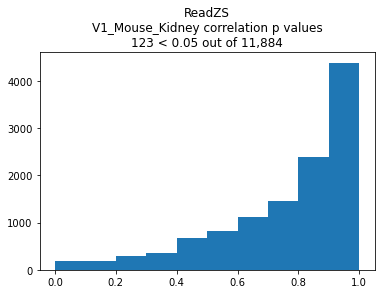

In [20]:
plt.hist(corrdf["pval_pixval_adj"])
plt.title("{}\n{} correlation p values\n{:,} < 0.05 out of {:,}".format(method,dataname,corrdf[corrdf["pval_pixval_adj"] < 0.05].shape[0],corrdf.shape[0]))
plt.show()

In [39]:
[x for x in corrdf["gene"].dropna().unique() if "Kdm5d" in x]

[]

In [15]:
spliz_df["gene"].value_counts()

ORM1                 4576
ALB                  3844
SAA1                 3611
MT2A                 3383
KLRG1,A2M-AS1,A2M    3325
                     ... 
EIF5B                   1
CNNM4                   1
LOC285074               1
SNRPG                   1
HINT2                   1
Name: gene, Length: 386, dtype: int64

chr10_25699_minus


/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
No handles with labels found to put in legend.


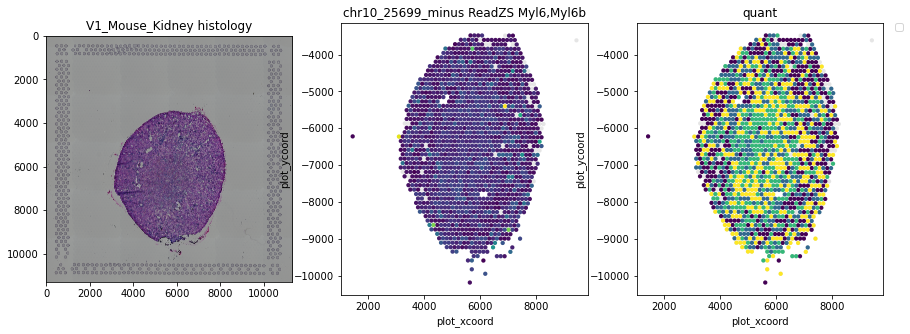

In [22]:
# for gene in tqdm(spliz_df[genecol].value_counts().index):
# for gene in tqdm(spliz_df.groupby(genecol)["frac_count"].sum().sort_values(ascending=False).index):
thresh = 0
upper = 1
lower = 0

legval = False
# for gene in tqdm(["Myl6","Rps24","Gng13"]):#,"Gng13","Myl6","Rps24","Kdm5d"]):
# for gene in tqdm(spliz_df["gene"].unique()):
# for gene in tqdm(["Aldob","Cmbl","Slc6a19"]):
# for gene in tqdm(["Rpl27A","Epcam","Uqcr11"]):
for gene in ["chr10_25699_minus"]:
# for gene in tqdm(spliz_df["gene"].value_counts().head(10).index):
# for gene in tqdm(corrdf[corrdf["num_genes"] == 1]["window"]):
# for gene in tqdm(corrdf[(corrdf["pval_pixval_adj"] < upper) & (corrdf["pval_pixval_adj"] > lower)][genecol].head(2)):
# for gene in tqdm(corrdf[(corrdf["pval_pixval_adj"] < upper) & (corrdf["pval_pixval_adj"] > lower) & (~corrdf[genecol].str.startswith("mt"))][genecol]):

  # for gene in ["chr4_23431_minus","chr2_34870_plus","chr19_1099_plus","chr17_17487_minus","chr11_1284_plus"]:
# for gene in corrdf["window"]:
# for gene in corrdf[genecol]:
  print(gene)
  gene_df = spliz_df[spliz_df[genecol] == gene]
  if gene_df.shape[0] > thresh:

    gene_df[col + "_quant"] = 1

    gene_df.loc[gene_df[col] > gene_df[col].quantile(.25),col + "_quant"] = 2
    gene_df.loc[gene_df[col] > gene_df[col].quantile(.5),col + "_quant"] = 3
    gene_df.loc[gene_df[col] > gene_df[col].quantile(.75),col + "_quant"] = 4

    fig, axs = plt.subplots(1,3, figsize=(15,5))


    sns.scatterplot(ax=axs[1],data = graydf, x=xcol, y = ycol,color="gray",alpha = alpha,size=3,linewidth=0,legend=False)

    sns.scatterplot(ax=axs[1],data = gene_df, x = xcol, y = ycol, hue = col,size=3,linewidth=0,palette="viridis",legend=legval)
    sns.scatterplot(ax=axs[2],data = graydf, x=xcol, y = ycol,color="gray",alpha = alpha,size=3,linewidth=0,legend=False)
    sns.scatterplot(ax=axs[2],data = gene_df, x = xcol, y = ycol, hue = col + "_quant",size=3,linewidth=0,palette="viridis",legend=legval)
    axs[2].set_title("quant")
    try:
      axs[1].set_title("{} {} {}".format(gene,method,corrdf[corrdf[genecol] == gene]["gene"].iloc[0]))
    except:
      axs[1].set_title("{} {} {}".format(gene,method, name_dict[gene]))

    axs[0].imshow(im)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axs[0].set_title("{} histology".format(dataname))
    plt.savefig("{}{}_{}_{}.png".format(outpath,dataname,gene,method))
    plt.show()

In [52]:
spliz_df["gene"].value_counts().head(100)

Hbb-bs    2718
Kap       2175
Hbb-bt    2023
Fxyd2     1962
Rps24     1660
          ... 
Cox5a      830
Ndufb5     830
Uba52      829
Edf1       818
Dnase1     818
Name: gene, Length: 100, dtype: int64

In [189]:
gene_df

148511    0.159790
148594    0.159790
148522    0.167666
73077     0.788263
73056    -0.787301
            ...   
148548    0.171167
148497   -0.847119
148532    0.159790
148531    0.193920
148595    0.180268
Name: scZ, Length: 162, dtype: float64

In [69]:
# blur_radius = 1000
blur_radius = 300
shuffle = False

if shuffle:
  display(gene_df[col])
  gene_df[col] = list(gene_df[col].sample(frac=1))
  display(gene_df[col])
  
run_interp = True
coord_df = graydf[[xcol,ycol,"cell"]].dropna().drop_duplicates([xcol,ycol,"cell"])
dfs = []

count = 100
subdf = spliz_df[genecol].value_counts().head(count)
for gene, gene_df in tqdm(spliz_df[spliz_df[genecol].isin(subdf.index)].groupby(genecol)):
  count += 1
#   if count == 100:
#     break
  new_vals = {xcol : [], ycol : [], "cell" : [], "interp" : [], "gene" : []}
  for index, row in coord_df.iterrows():

    temp = gene_df[(gene_df[xcol] > row[xcol] - blur_radius) & (gene_df[xcol] < row[xcol] + blur_radius) & (gene_df[ycol] > row[ycol] - blur_radius) & (gene_df[ycol] < row[ycol] + blur_radius)]
    new_vals[xcol].append(row[xcol])
    new_vals[ycol].append(row[ycol])
    new_vals["interp"].append(temp[col].dropna().mean())
    new_vals["cell"].append(row["cell"])
    new_vals["gene"].append(gene)

  if run_interp:
    interp = pd.DataFrame.from_dict(new_vals)

    new_vals = {xcol : [], ycol : [], "blur" : [],"cell" : [], "gene" : []}
    for index, row in coord_df.iterrows():

      temp = interp[(interp[xcol] > row[xcol] - blur_radius) & (interp[xcol] < row[xcol] + blur_radius) & (interp[ycol] > row[ycol] - blur_radius) & (interp[ycol] < row[ycol] + blur_radius)]
      new_vals[xcol].append(row[xcol])
      new_vals[ycol].append(row[ycol])
      new_vals["cell"].append(row["cell"])
      new_vals["gene"].append(gene)
      new_vals["blur"].append(temp["interp"].dropna().mean())

  blur = pd.DataFrame.from_dict(new_vals)
  if not run_interp:
    blur.rename(columns={"interp" : "blur"},inplace=True)
  blur = add_quant_col(blur,"blur")
  dfs.append(blur)


100%|██████████| 100/100 [03:39<00:00,  2.20s/it]


In [70]:
fulldf = pd.concat(dfs)
fulldf

,plot_xcoord,plot_ycoord,blur,cell,gene,blur_quant
0,6467.0,-4202.0,-0.016640,V1_Mouse_Kidney_ATCTGGTTAAGACTGT,Akr1c21,2.0
1,7005.0,-7557.0,-0.029082,V1_Mouse_Kidney_GCTAGGCACCACGGAG,Akr1c21,1.0
2,4330.0,-5033.0,0.023453,V1_Mouse_Kidney_ATAGACGAAGAGAAAG,Akr1c21,3.0
3,7002.0,-8514.0,0.020685,V1_Mouse_Kidney_GTGATCCTTGTCATGA,Akr1c21,3.0
4,5500.0,-5157.0,-0.031134,V1_Mouse_Kidney_ACGCGGGCCAAGGACA,Akr1c21,1.0
...,...,...,...,...,...,...
1426,8179.0,-6483.0,-0.035116,V1_Mouse_Kidney_AAGTCAATTGTCGTCA,Uqcrq,1.0
1427,3222.0,-7184.0,0.039670,V1_Mouse_Kidney_AGTCGTGGGCATTACG,Uqcrq,2.0
1428,8113.0,-5645.0,0.193176,V1_Mouse_Kidney_ACCCGGATGACGCATC,Uqcrq,4.0
1429,6527.0,-6717.0,0.021542,V1_Mouse_Kidney_TCGTGTACTATGGATG,Uqcrq,2.0


In [71]:
val = "blur"
mat = pd.DataFrame(index=fulldf["cell"].unique(),columns=fulldf["gene"].unique())

for gene, gene_fulldf in tqdm(fulldf.groupby("gene")):
  mat[gene] = mat.index.map({k : v for k, v in zip(gene_fulldf["cell"],gene_fulldf[val])})
  

100%|██████████| 100/100 [00:00<00:00, 677.22it/s]


/home/groups/horence/applications/anaconda3/envs/jup_env/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


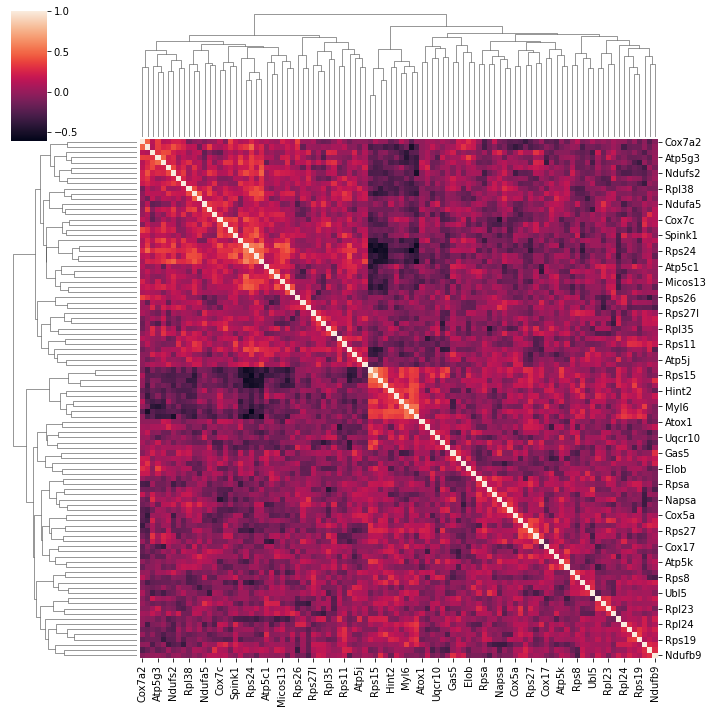

In [72]:
mat
corr_mat = mat.corr(method="spearman")
sns.clustermap(corr_mat.fillna(0))
plt.savefig("{}{}_{}.png".format(outpath,dataname,val))

/home/groups/horence/applications/anaconda3/envs/jup_env/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


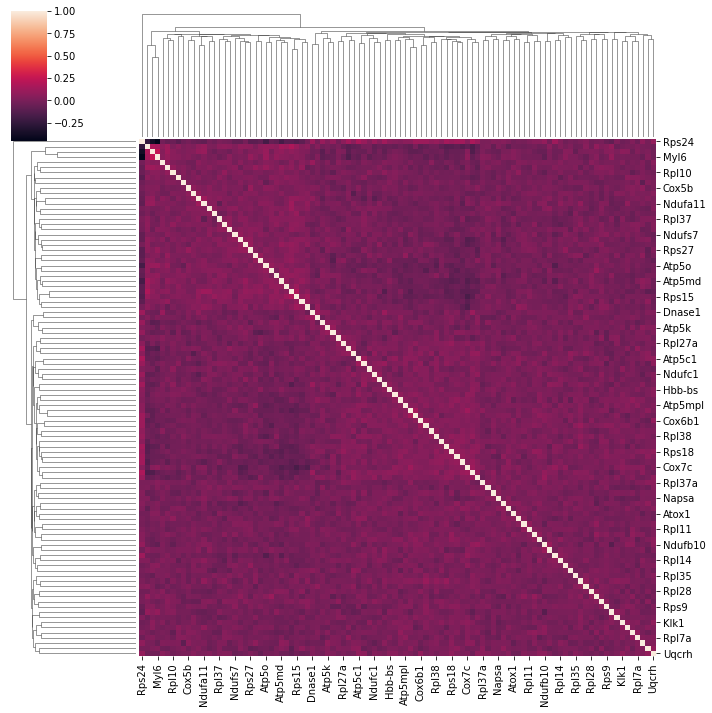

In [63]:
mat
corr_mat = mat.corr(method="spearman")
sns.clustermap(corr_mat.fillna(0))
plt.savefig("{}{}_{}.png".format(outpath,dataname,val))

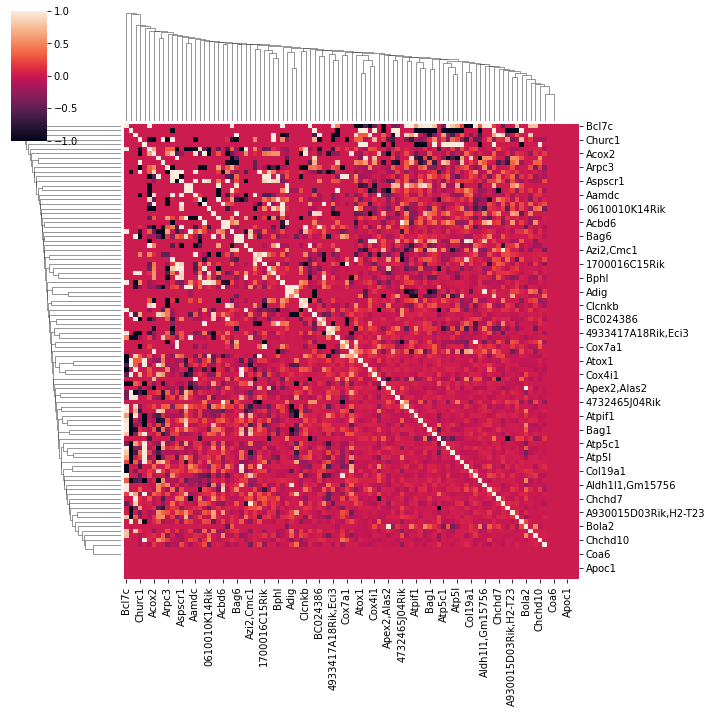

In [46]:
mat
corr_mat = mat.corr(method="spearman")
sns.clustermap(corr_mat.fillna(0))
plt.savefig("{}{}_{}.png".format(outpath,dataname,val))

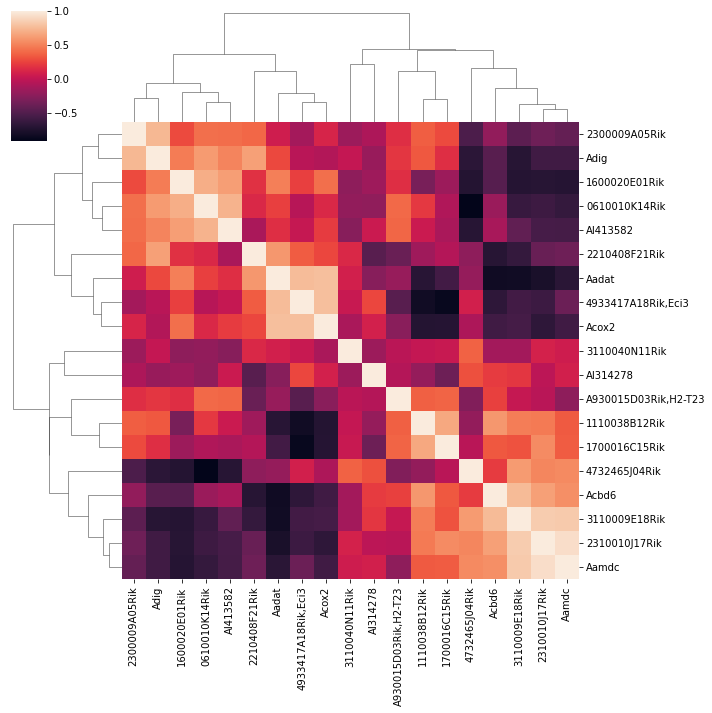

In [38]:
mat
corr_mat = mat.corr(method="spearman")
sns.clustermap(corr_mat.fillna(0))
plt.savefig("{}{}_{}.png".format(outpath,dataname,val))

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15,5))


sns.scatterplot(ax=axs[1],data = graydf, x=xcol, y = ycol,color="gray",alpha = alpha,size=3,linewidth=0,legend=False)

sns.scatterplot(ax=axs[1],data = blur, x = xcol, y = ycol, hue = "blur",size=3,linewidth=0,palette="viridis",legend=legval)
sns.scatterplot(ax=axs[2],data = graydf, x=xcol, y = ycol,color="gray",alpha = alpha,size=3,linewidth=0,legend=False)
sns.scatterplot(ax=axs[2],data = blur, x = xcol, y = ycol, hue = "blur" + "_quant",size=3,linewidth=0,palette="viridis",legend=legval)
axs[2].set_title(blur_radius)
if shuffle:
  axs[0].set_title("{} shuffle".format(gene))
else:
  axs[0].set_title(gene)
axs[0].imshow(im)
if run_interp:
  axs[1].set_title("interp-->blur")
else:
  axs[1].set_title("blur")

In [84]:
temp[[xcol,ycol,col]]

,plot_xcoord,plot_ycoord,scZ
27754,6397.0,-4561.0,0.012318
27782,6811.0,-4084.0,0.012318
27786,6259.0,-4561.0,-0.891899
27790,6260.0,-4321.0,0.012318
27893,6398.0,-4082.0,0.012318
27905,6399.0,-3843.0,0.012318
167927,6949.0,-4084.0,0.111084
167930,6054.0,-4201.0,0.111084
168016,6190.0,-4680.0,0.111084


In [75]:
row

plot_xcoord    6467.0
plot_ycoord   -4202.0
Name: 0, dtype: float64

In [73]:
graydf[["xcoord","ycoord"]].dropna().drop_duplicates(["xcoord","ycoord"])

,xcoord,ycoord
0,4202.0,6467.0
1,7557.0,7005.0
2,5033.0,4330.0
3,8514.0,7002.0
4,5157.0,5500.0
...,...,...
80211,6483.0,8179.0
113904,7184.0,3222.0
113980,5645.0,8113.0
132328,6717.0,6527.0


In [72]:
(graydf[xcol].astype(str) + "_" + graydf[xcol].astype(str)).nunique()

1219

In [56]:
row

plot_xcoord            7422.0
plot_ycoord           -6361.0
scZ                  0.012318
x_y            7422.0_-6361.0
scZ_quant                 1.0
Name: 27606, dtype: object

In [13]:
gene_df["scZ"]

0

In [37]:
gene_df["x_y"] = gene_df[xcol].astype(str) + "_" + gene_df[ycol].astype(str)
sub_gene_df = gene_df[[xcol,ycol,col,"x_y"]].dropna()
sub_gene_df

/home/users/jolivier/.local/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,plot_xcoord,plot_ycoord,scZ,x_y
27606,7422.0,-6361.0,0.012318,7422.0_-6361.0
27607,4803.0,-7549.0,0.012318,4803.0_-7549.0
27608,5351.0,-8269.0,0.012318,5351.0_-8269.0
27609,6461.0,-5878.0,-1.088653,6461.0_-5878.0
27611,7003.0,-8275.0,0.012318,7003.0_-8275.0
...,...,...,...,...
168019,5633.0,-6354.0,0.111084,5633.0_-6354.0
168020,4461.0,-6949.0,0.111084,4461.0_-6949.0
168021,7217.0,-6001.0,0.111084,7217.0_-6001.0
168022,6871.0,-6598.0,0.111084,6871.0_-6598.0


In [39]:
nan_df = pd.concat([sub_gene_df,newdf])
nan_df

,plot_xcoord,plot_ycoord,scZ,x_y
27606,7422.0,-6361.0,0.012318,7422.0_-6361.0
27607,4803.0,-7549.0,0.012318,4803.0_-7549.0
27608,5351.0,-8269.0,0.012318,5351.0_-8269.0
27609,6461.0,-5878.0,-1.088653,6461.0_-5878.0
27611,7003.0,-8275.0,0.012318,7003.0_-8275.0
...,...,...,...,...
1426,7547.0,4390.0,NaN,7547.0_4390.0
1427,7797.0,7142.0,NaN,7797.0_7142.0
1428,6599.0,7146.0,NaN,6599.0_7146.0
1429,4565.0,7635.0,NaN,4565.0_7635.0


In [38]:
newdf = pd.DataFrame({"x_y" : list(set(temp["x_y"]) - set(sub_gene_df["x_y"]))})
newdf[xcol] = newdf["x_y"].str.split("_").str[0].astype(float)
newdf[ycol] = newdf["x_y"].str.split("_").str[1].astype(float)
newdf[col] = np.nan
newdf

,x_y,plot_xcoord,plot_ycoord,scZ
0,3721.0_5918.0,3721.0,5918.0,NaN
1,4322.0_6397.0,4322.0,6397.0,NaN
2,5520.0_6668.0,5520.0,6668.0,NaN
3,6481.0_7491.0,6481.0,7491.0,NaN
4,8152.0_5971.0,8152.0,5971.0,NaN
...,...,...,...,...
1426,7547.0_4390.0,7547.0,4390.0,NaN
1427,7797.0_7142.0,7797.0,7142.0,NaN
1428,6599.0_7146.0,6599.0,7146.0,NaN
1429,4565.0_7635.0,4565.0,7635.0,NaN


In [22]:
temp = graydf[["xcoord","ycoord"]].dropna().drop_duplicates()
temp["x_y"] = temp["xcoord"].astype(str) + "_" + temp["ycoord"].astype(str)
temp

,xcoord,ycoord,x_y
0,4202.0,6467.0,4202.0_6467.0
1,7557.0,7005.0,7557.0_7005.0
2,5033.0,4330.0,5033.0_4330.0
3,8514.0,7002.0,8514.0_7002.0
4,5157.0,5500.0,5157.0_5500.0
...,...,...,...
80211,6483.0,8179.0,6483.0_8179.0
113904,7184.0,3222.0,7184.0_3222.0
113980,5645.0,8113.0,5645.0_8113.0
132328,6717.0,6527.0,6717.0_6527.0


In [31]:
spliz_df.shape

(16907080, 12)